# 3DoF inverse kinematics
3自由度マニピュレータの順運動学です。

## Denavit-Hartenberg parameters
|$^{i-1}T_i$|$a_i$|$\alpha_i$|$d_i$|$\theta_i$|
|---|---|---|---|---|
|$^{B}T_1$  |0    |0         |0    |$\theta_1$|
|$^{1}T_2$  |0    |$\pi$/2 |0    |$\theta_2$|
|$^{2}T_3$  |1    |0         |0    |$\theta_3$|
|$^{3}T_E$  |1    |0         |0    |0         |

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Homogeneous transformation matrix
# 同次変換行列
def trans_m(a, alpha, d, theta):
    m = np.array([[np.cos(theta), -np.sin(theta), 0., a],
                  [np.cos(alpha)*np.sin(theta), np.cos(alpha)*np.cos(theta), -np.sin(alpha), -np.sin(alpha)*d],
                  [np.sin(alpha)*np.sin(theta), np.sin(alpha)*np.cos(theta),  np.cos(alpha),  np.cos(alpha)*d],
                  [0., 0., 0., 1.]])
    return m

In [3]:
# Forward kinematics
# 順運動学
def fk(theta):
    tm0_1 = trans_m(0, 0,       0, theta[0,0])
    tm1_2 = trans_m(0, np.pi/2, 0, theta[1,0])
    tm2_3 = trans_m(1, 0,       0, theta[2,0])
    tm3_4 = trans_m(1, 0,       0, 0)
    pos = [tm0_1[0:3,3:4],
           tm0_1.dot(tm1_2)[0:3,3:4],
           tm0_1.dot(tm1_2).dot(tm2_3)[0:3,3:4],
           tm0_1.dot(tm1_2).dot(tm2_3).dot(tm3_4)[0:3,3:4]]
    return pos

## ヤコビ行列
まず関節角ベクトル$q$, 手先位置ベクトル$r$を下記のように定義します。

$$
\begin{align*}
q&=\begin{bmatrix} \theta _{1} \\ \theta _{2} \\ \theta _{3} \end{bmatrix}\\
r&=\begin{bmatrix}
x \\
y \\
z
\end{bmatrix}
\end{align*}
$$

するとヤコビ行列は下記のように定義されます。

$$
J\left( q\right) =
\begin{bmatrix}
\dfrac {\partial x}{\partial \theta _{1}} & \dfrac {\partial x}{\partial \theta _{2}} & \dfrac {\partial x}{\partial \theta _{3}} \\
\dfrac {\partial y}{\partial \theta _{1}} & \dfrac {\partial y}{\partial \theta _{2}} & \dfrac {\partial y}{\partial \theta _{3}} \\
\dfrac {\partial z}{\partial \theta _{1}} & \dfrac {\partial z}{\partial \theta _{2}} & \dfrac {\partial z}{\partial \theta _{3}}
\end{bmatrix}
$$

ヤコビ行列の各要素は下記の通りです。

$$
J_{ij}=\dfrac {\partial r_i}{\partial q_j}
$$

In [4]:
# Jacobian matrix
# ヤコビ行列
def J(theta):
    e = 1.0e-10
    diff_q1 = (fk(theta+np.array([[e],[0.],[0.]]))[3]-fk(theta)[3])/e
    diff_q2 = (fk(theta+np.array([[0.],[e],[0.]]))[3]-fk(theta)[3])/e
    diff_q3 = (fk(theta+np.array([[0.],[0.],[e]]))[3]-fk(theta)[3])/e
    return np.hstack((diff_q1, diff_q2, diff_q3))

In [5]:
# マニピュレータの描画
def draw(r, q, r_ref):
    xs = [e[0,0] for e in r]
    ys = [e[1,0] for e in r]
    zs = [e[2,0] for e in r]
    xg, yg, zg = r_ref
    
    fig = plt.figure(figsize=(10,10))
    
    sp = fig.add_subplot(221,aspect='equal')
    sp.set_xlim(-2,2)
    sp.set_ylim(-2,2)
    plt.plot(xg, yg, "o", color="red", ms=15, label="r_ref")
    plt.plot(xs, ys, "-", color="skyblue", lw=5, label="link")
    plt.plot(xs, ys, "o", color="orange", ms=10, label="joint")
    plt.title("x-y")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.legend(fontsize=10)
    
    sp = fig.add_subplot(222,aspect='equal')
    sp.set_xlim(-2,2)
    sp.set_ylim(-2,2)
    plt.plot(yg, zg, "o", color="red", ms=15, label="r_ref")
    plt.plot(ys, zs, "-", color="skyblue", lw=5, label="link")
    plt.plot(ys, zs, "o", color="orange", ms=10, label="joint")
    plt.title("y-z")
    plt.xlabel("y")
    plt.ylabel("z")
    plt.grid()
    plt.legend(fontsize=10)
    
    sp = fig.add_subplot(223,aspect='equal')
    sp.set_xlim(-2,2)
    sp.set_ylim(-2,2)
    plt.plot(xg, zg, "o", color="red", ms=15, label="r_ref")
    plt.plot(xs, zs, "-", color="skyblue", lw=5, label="link")
    plt.plot(xs, zs, "o", color="orange", ms=10, label="joint")
    plt.title("x-z")
    plt.xlabel("x")
    plt.ylabel("z")
    plt.grid()
    plt.legend(fontsize=10)
    
    ax = fig.add_subplot(224,aspect='equal',projection='3d')
    plt.plot(xg, yg, zg, "o", color="red", ms=15)
    ax.plot(xs, ys, zs, "-", color="skyblue", lw=5)
    ax.plot(xs, ys, zs, "o", color="orange", ms=10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.set_zlim(-2,2)
    
    plt.tight_layout()
    plt.show()
    
    print("r: "+str(r[3].T))
    print("q: "+str(q.T))

## 数値計算
初期値$q_0$を設定し、下式を繰り返し計算します。
$$
\begin{align*}
r_i&=f(q_i)\\
q_{i+1}&=q_i-J(q_i)^{-1}(r_i-r_{ref})
\end{align*}
$$

In [6]:
# 初期関節角
q = np.array([[np.pi/6],
              [np.pi/6],
              [np.pi/6]])

# 目標手先位置
r_ref = np.array([[1.],
                  [0.5],
                  [0.5]])

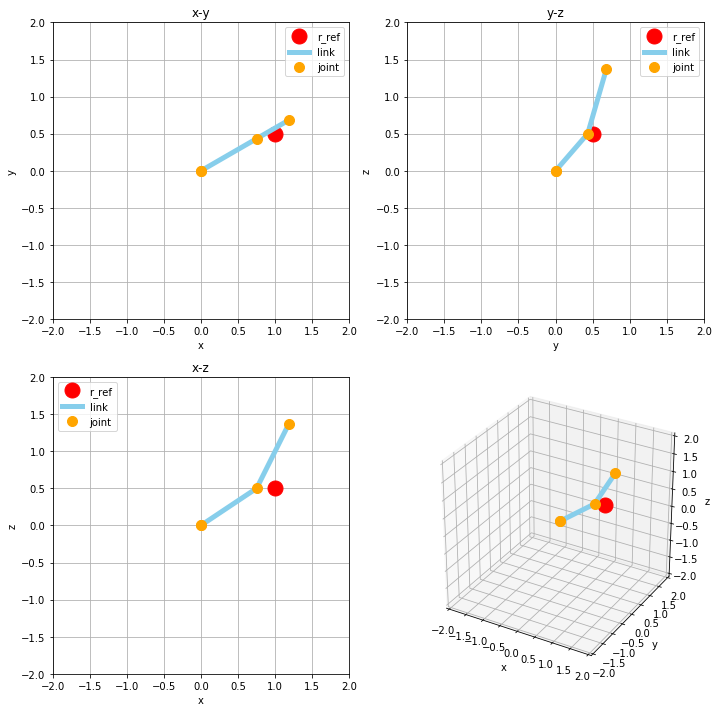

r: [[1.1830127 0.6830127 1.3660254]]
q: [[0.52359878 0.52359878 0.52359878]]


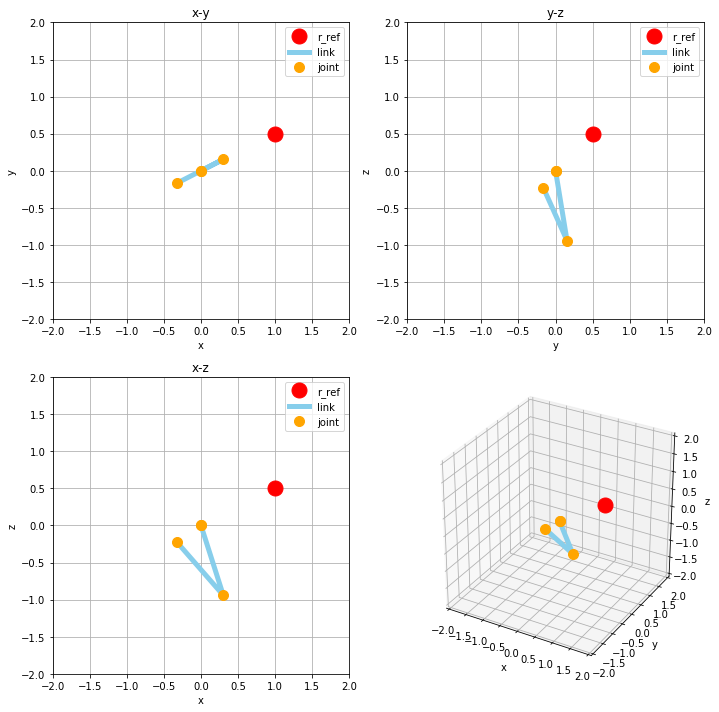

r: [[-0.32235283 -0.16559814 -0.22716456]]
q: [[ 0.47456093 -1.22640074  3.57263415]]


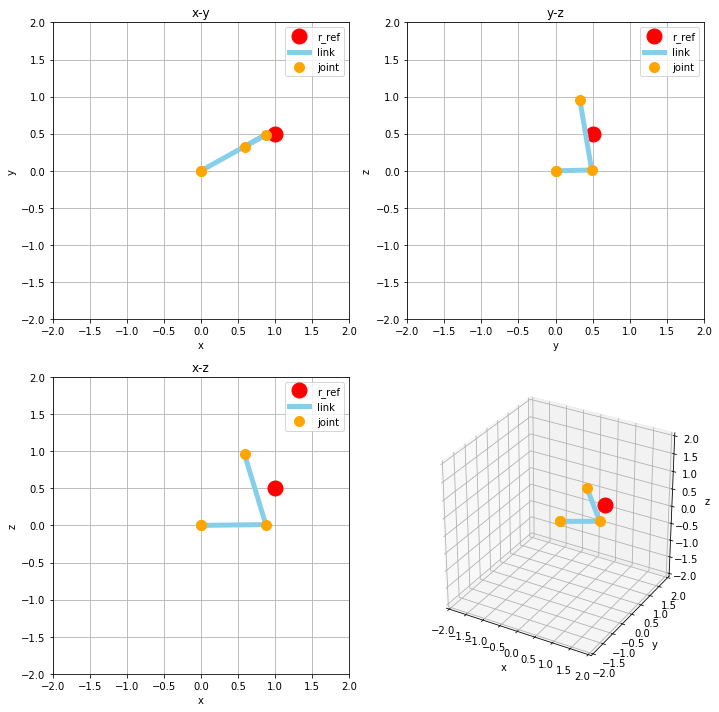

r: [[0.58758594 0.32730299 0.95593282]]
q: [[0.50822448 0.01102776 1.89325976]]


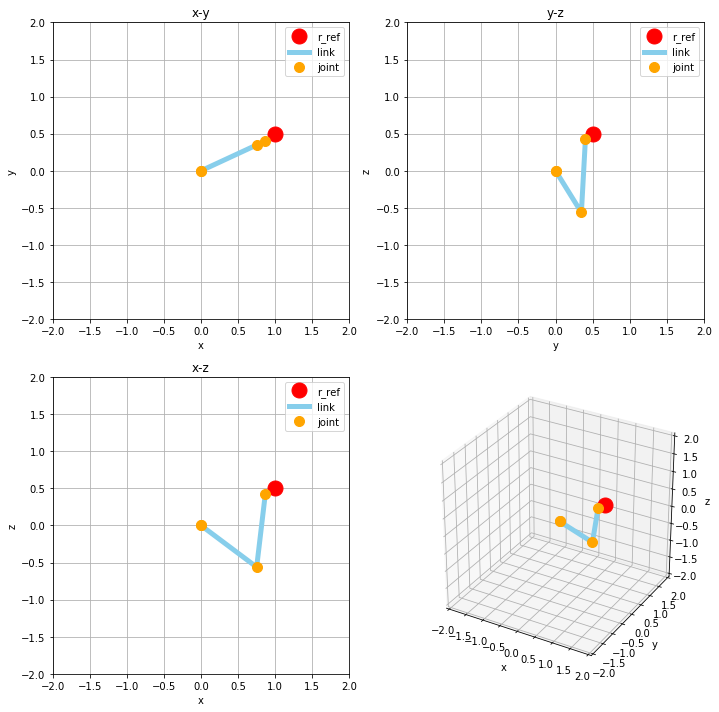

r: [[0.8678261  0.4023711  0.42981551]]
q: [[ 0.43415045 -0.59654949  2.03769268]]


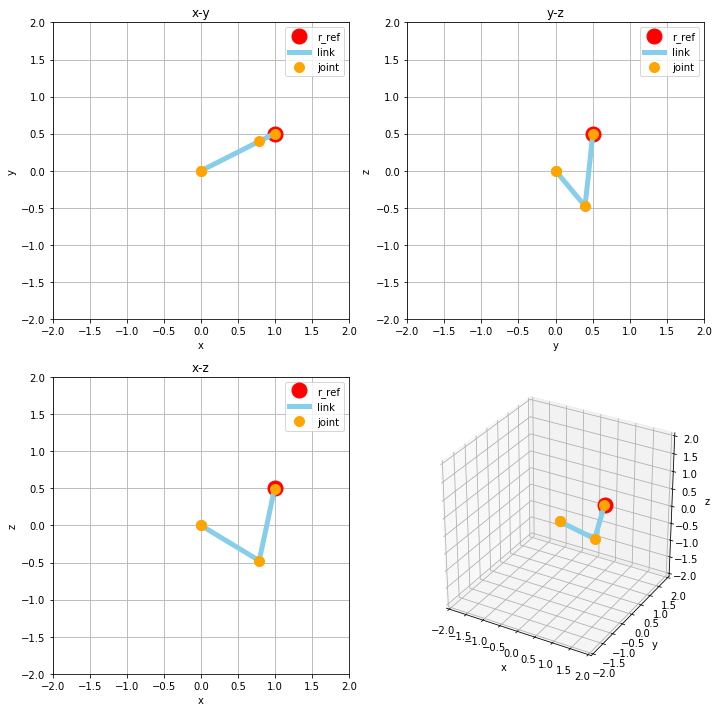

r: [[0.99239481 0.50238312 0.49729955]]
q: [[ 0.46862166 -0.49530483  1.83146681]]


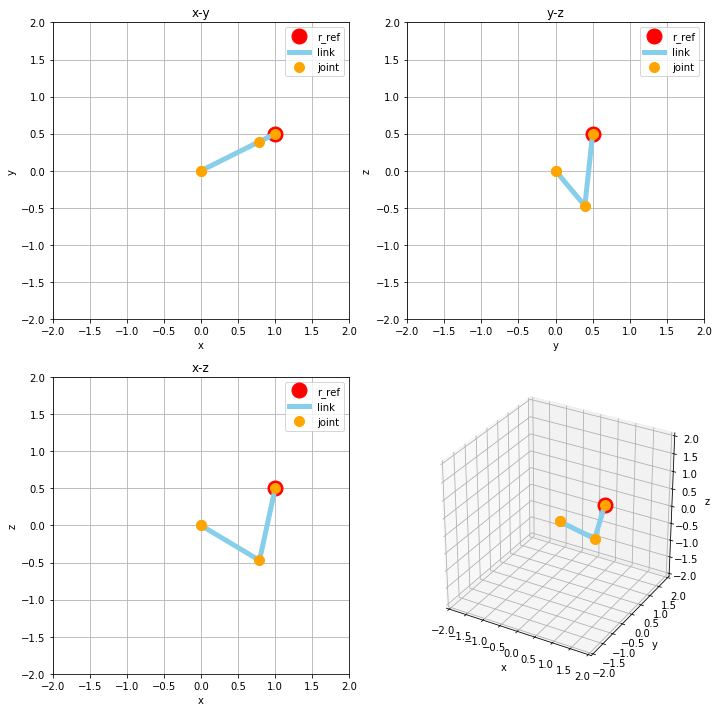

r: [[0.99999226 0.49996416 0.49999669]]
q: [[ 0.46362204 -0.49121288  1.8235048 ]]


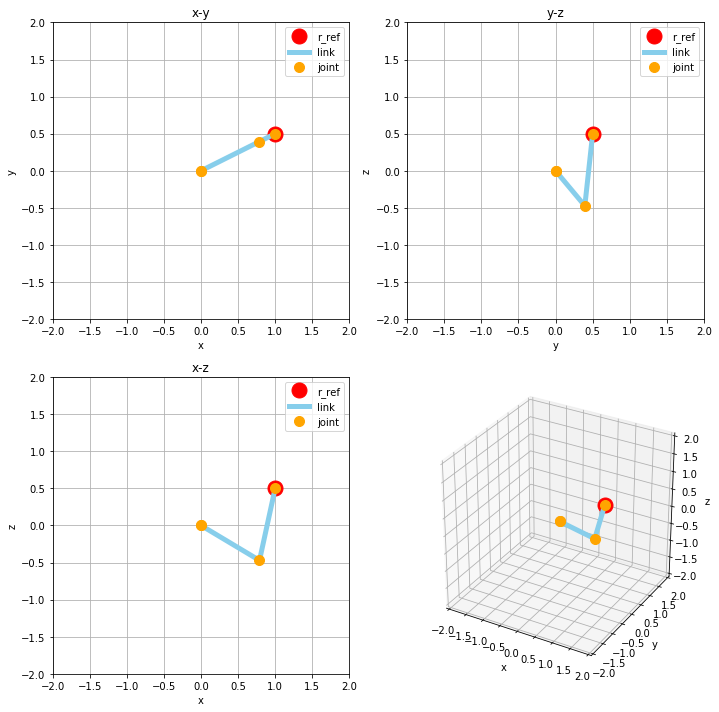

r: [[1.  0.5 0.5]]
q: [[ 0.46364761 -0.49120396  1.82347658]]


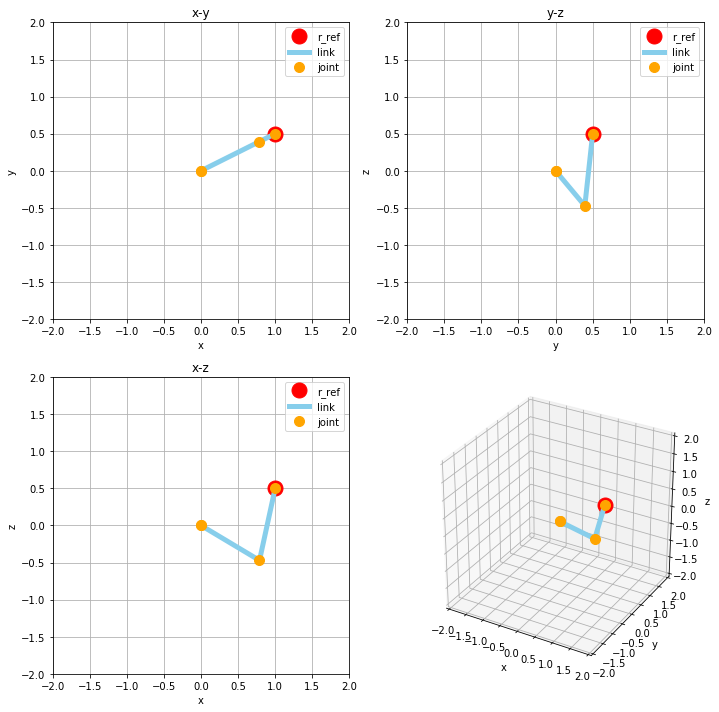

r: [[1.  0.5 0.5]]
q: [[ 0.46364761 -0.49120396  1.82347658]]


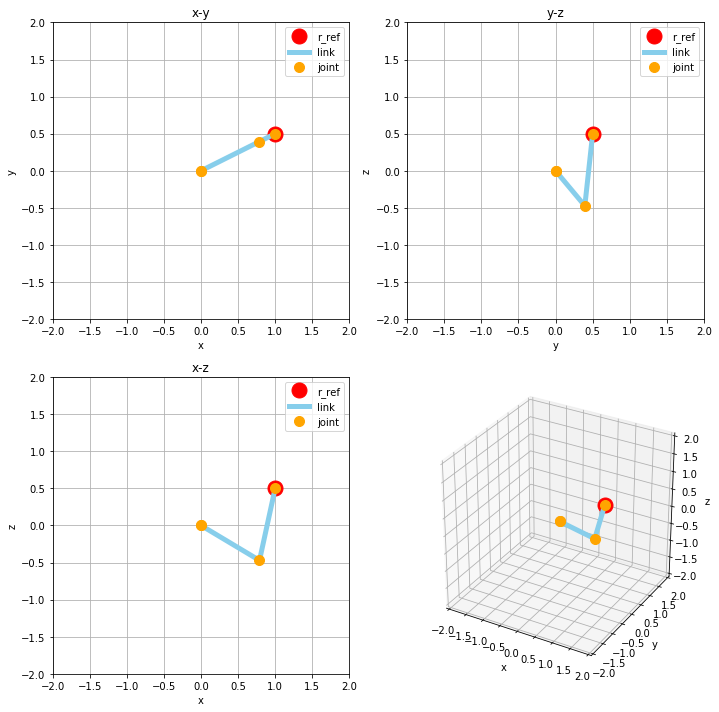

r: [[1.  0.5 0.5]]
q: [[ 0.46364761 -0.49120396  1.82347658]]


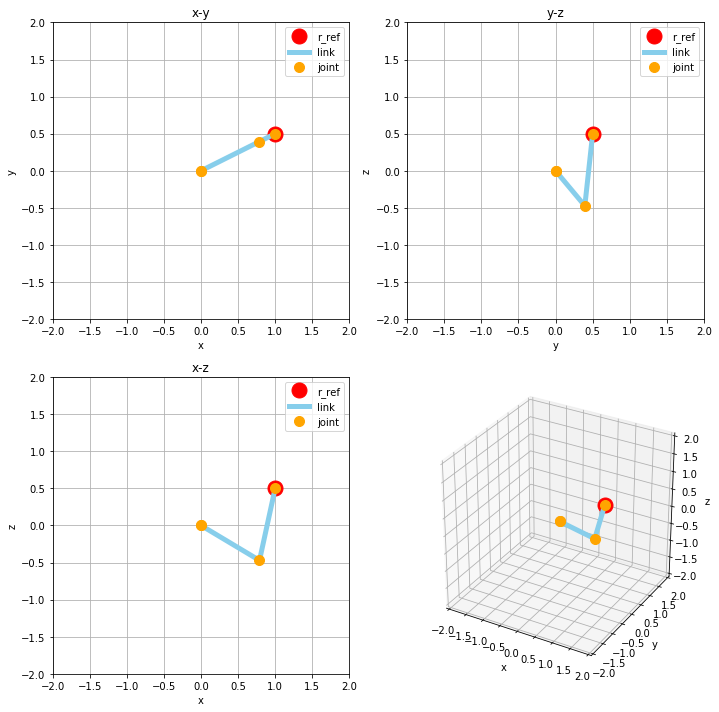

r: [[1.  0.5 0.5]]
q: [[ 0.46364761 -0.49120396  1.82347658]]


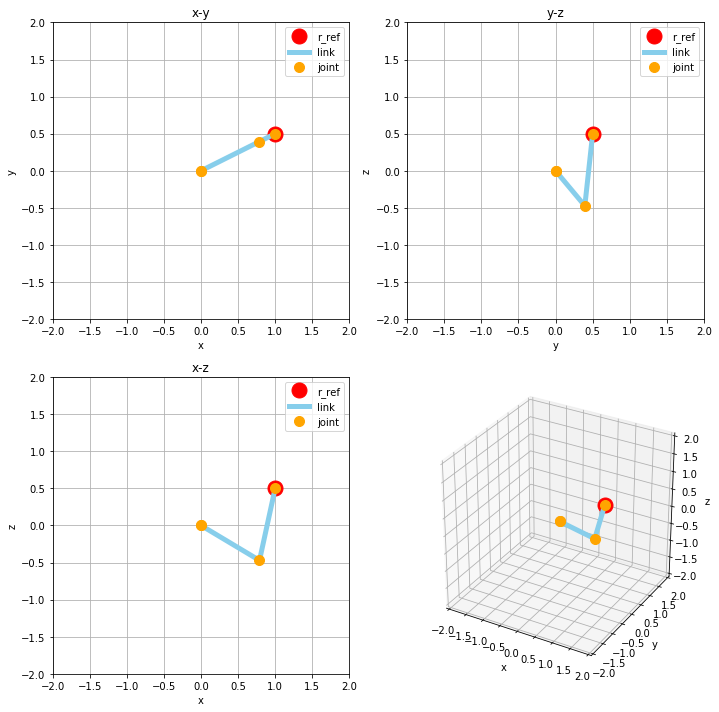

r: [[1.  0.5 0.5]]
q: [[ 0.46364761 -0.49120396  1.82347658]]


In [7]:
# 数値計算
for i in range(10):
    r = fk(q)
    draw(r, q, r_ref)
    q = q - np.linalg.inv(J(q)).dot((r[3] - r_ref))

r = fk(q)
draw(r, q, r_ref)